# AMS and f(RH) Time Series

Import functions

In [211]:
from funcs import * # funcs include functions used across scripts
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

Read in the data

In [212]:
o = read_all('OPTICAL') # optical data
inl = read_all('InletFlag') # inlet flag
a = read_all('AMS') # ams
mn = read_all('MetNav') # met nav

In [213]:
retrieval_paths = sorted(glob.glob('../data/v2/*/*/*.csv'))
retrieval_list = []
for i in range(0, len(retrieval_paths)):
    retrieval_list.append(pd.read_csv(retrieval_paths[i], parse_dates=['Start_Date_Time_UTC', 'Stop_Date_Time_UTC']))
r = pd.concat(retrieval_list)

Code used to plot a variable over the course of the entire campaign

In [214]:
def remove_nan(d, var):
    return d[np.isfinite(d[var])].reset_index(drop=True)

In [215]:
def add_line(x,y):
    m , b = np.polyfit(x, y, 1)
    x2 = np.linspace(x.min(), x.max(), 1000)
    y2 = x2*m + b
    return x2,y2

In [216]:
def var_plot(d, var, var_label, time_index = 'Time_Mid', hline = None):
    fig,ax = plt.subplots(figsize=(9,3))

    d_small = d[[time_index, var]] # only using columns of interest for resampling

    # resample data
    d_resamp = d_small.resample('2h', on=time_index).quantile(.50).reset_index()
    d_resamp_75 = d_small.resample('2h', on=time_index).quantile(.75).reset_index()
    d_resamp_25 = d_small.resample('2h', on=time_index).quantile(.25).reset_index()

    # remove nan
    d_resamp = remove_nan(d_resamp, var)
    d_resamp_25 = remove_nan(d_resamp_25, var)
    d_resamp_75 = remove_nan(d_resamp_75, var)

    # add text to plot displaying to total number of points
    count_text = 'N = ' + str(len(d[np.isfinite(d[var])][var]))
    ax.text(.99, .98, count_text, ha='right', va='top', transform=ax.transAxes)

    # plot the resampled data with error bars
    ax.errorbar(d_resamp.index, d_resamp[var], yerr=(d_resamp_75[var]-d_resamp[var], d_resamp[var]-d_resamp_25[var]), c='black', fmt='.')

    # add a trend line
    x,y = add_line(d_resamp.index,d_resamp[var])
    plt.plot(x,y, ls = '--', c='red')

    # mark on figure changes in day
    day_changes = d_resamp[time_index].dt.date.diff().ne(pd.Timedelta(0))
    flight_ind = list(d_resamp[day_changes].index)
    day_ticks = []
    for i in range(0,len(flight_ind)):
        ax.axvline(flight_ind[i], 0, 1, alpha=.2, c='black')
        date = d_resamp.loc[flight_ind[i]][time_index]
        day_ticks.append(str(date.month) + '/' + str(date.day))

    # add a horizontal reference line
    if hline is not None:
        ax.axhline(y=hline, c='black', ls='--', alpha=.2)

    ax.set_xticks(flight_ind)
    ax.set_xticklabels(day_ticks, rotation=90)
    ax.set_xlabel('Date [M/DD]')
    ax.set_ylabel(var_label)

    fig.tight_layout()
    fig.savefig('../figures/overview_ts_'+var+'.png', dpi=300)

## Plotting overview figures

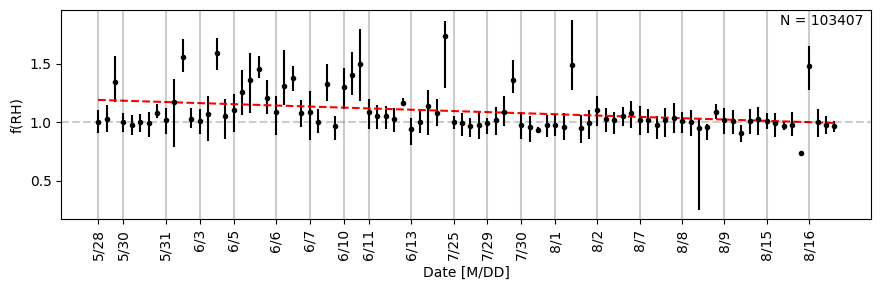

In [217]:
var_plot(o,'fRH550_RH20to80', 'f(RH)', hline = 1)

In [218]:
ams_keys = ['Org_Ave_IsoK_STP','SO4_Ave_IsoK_STP','NO3_Ave_IsoK_STP','NH4_Ave_IsoK_STP','Chl_Ave_IsoK_STP']
a['tot'] = a[ams_keys].sum(axis=1)
a = a[a['tot']>.4]
a['OMF'] = a['Org_Ave_IsoK_STP']/a['tot']
a['SMF'] = a['SO4_Ave_IsoK_STP']/a['tot']

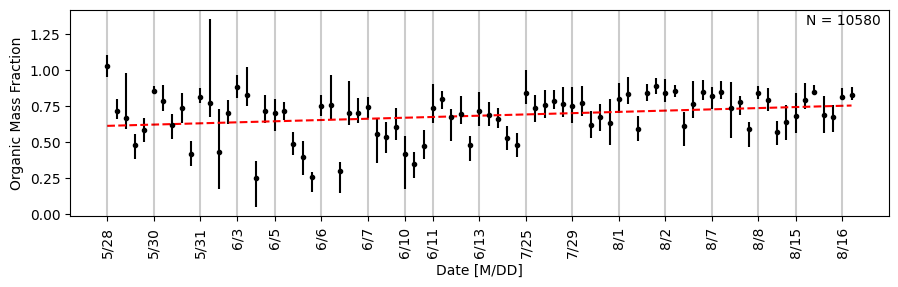

In [219]:
var_plot(a, 'OMF', 'Organic Mass Fraction')

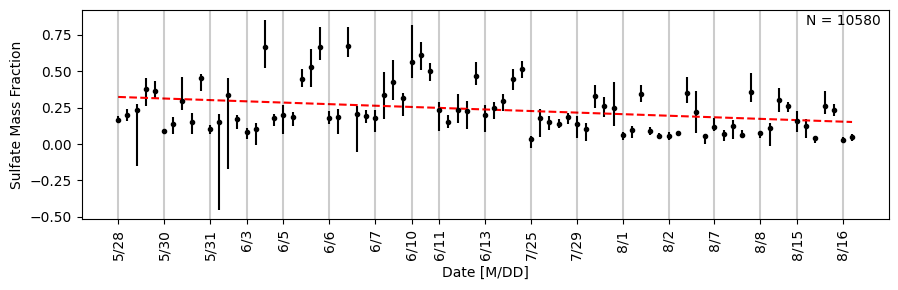

In [220]:
var_plot(a, 'SMF', 'Sulfate Mass Fraction')

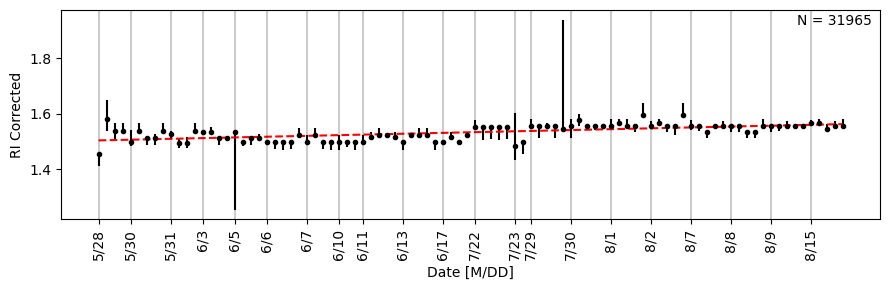

In [221]:
var_plot(r, 'RI_corr', 'RI Corrected', time_index='Start_Date_Time_UTC')

In [222]:
r_dps = []
dps = sorted(r['SEMS_Dp'].unique())
for i in range(0,len(dps)):
    r_dps.append(r[(np.abs(r['RH']-85)<5)& (r['SEMS_Dp']==dps[i])])

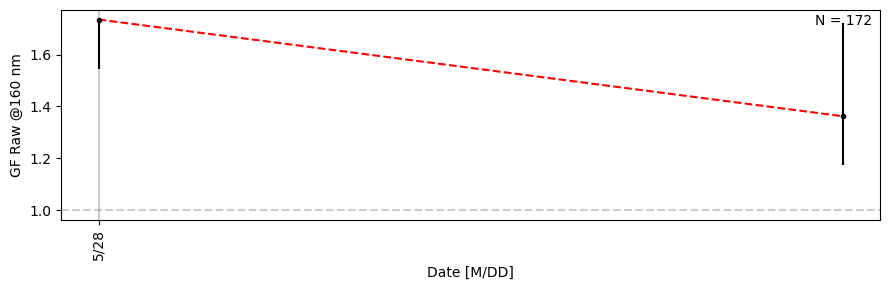

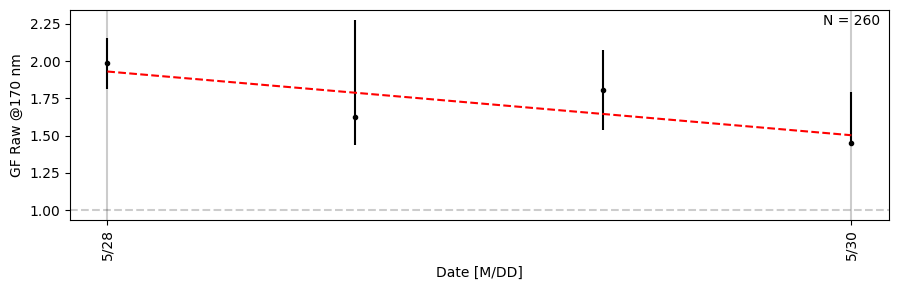

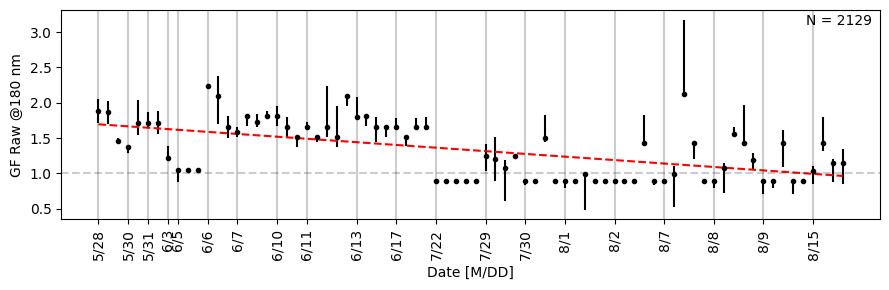

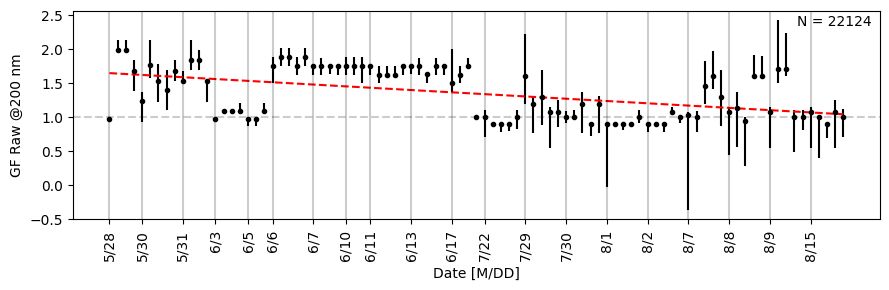

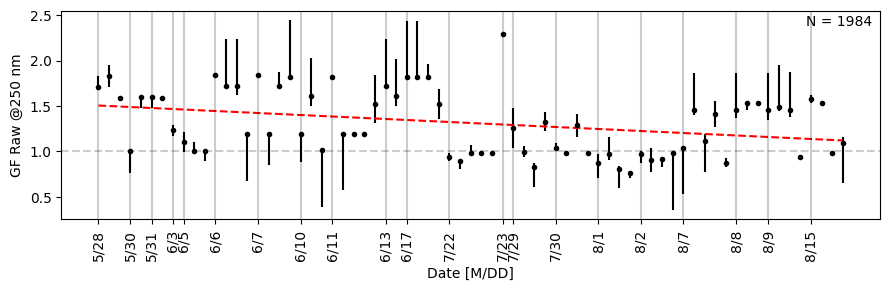

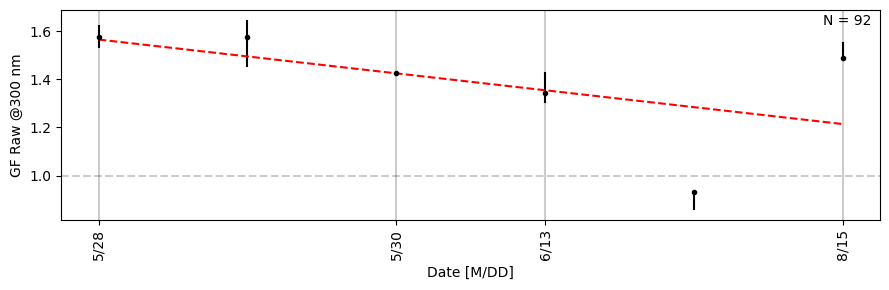

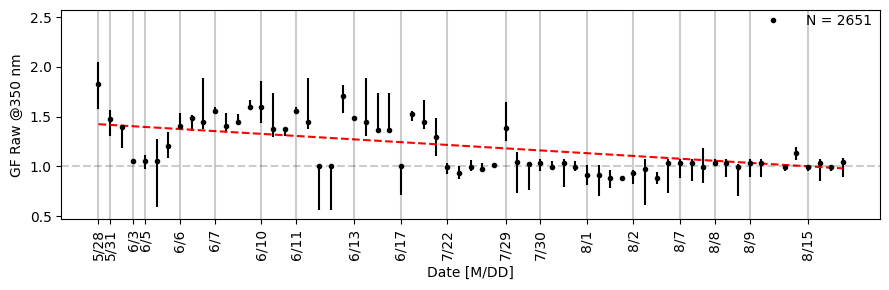

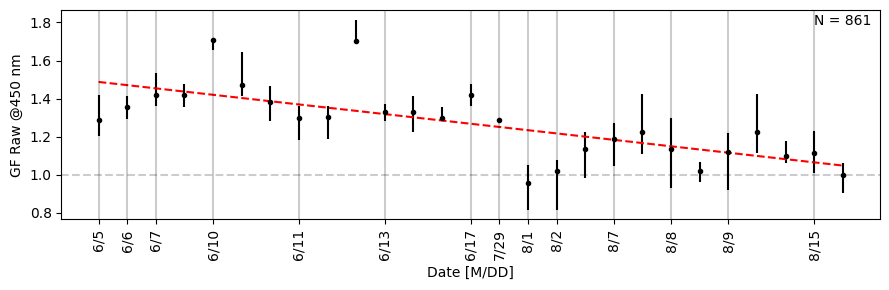

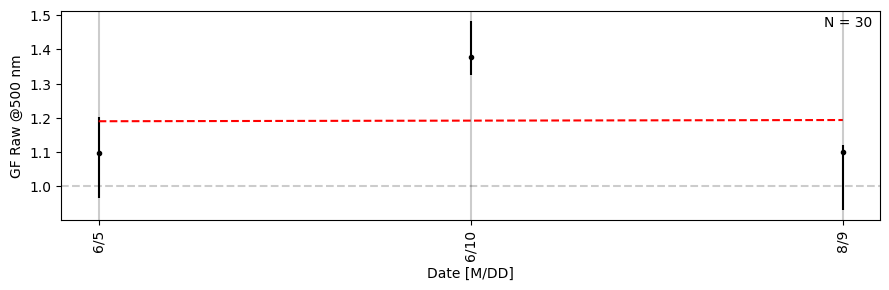

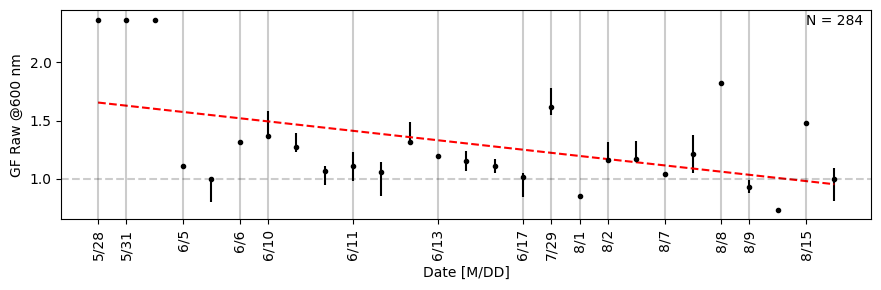

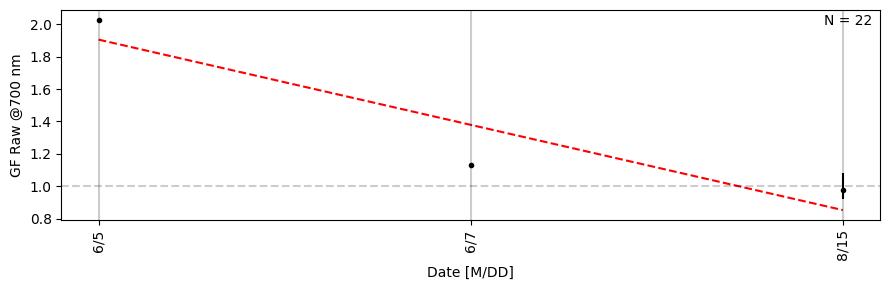

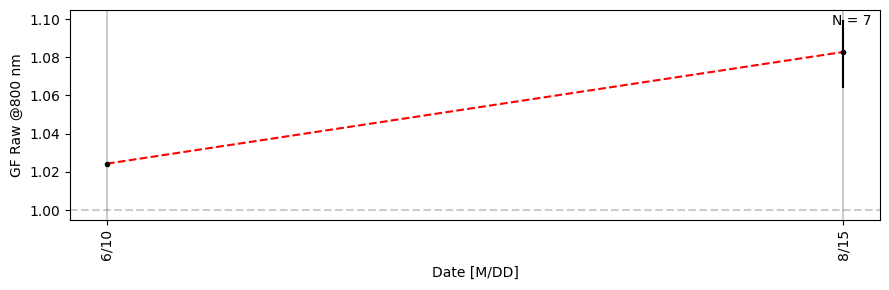

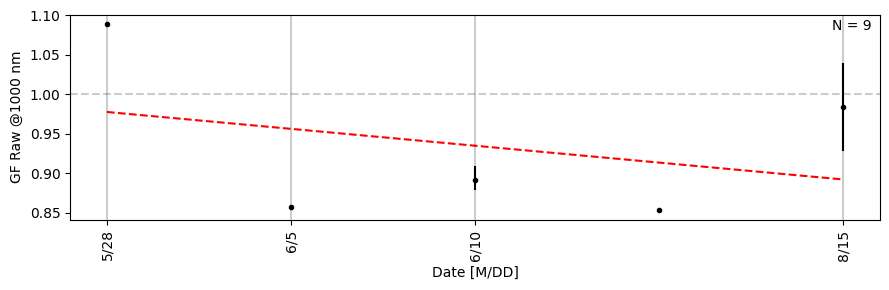

In [223]:
for i in range(0, len(dps)):
    d_label = str(int(dps[i]))
    r_dps[i] = r_dps[i].rename(columns={'GF_raw':'GF_raw_'+d_label})
    var_plot(r_dps[i], 'GF_raw_'+d_label, 'GF Raw @' + d_label + ' nm', time_index='Start_Date_Time_UTC', hline = 1)

## Plotting flight specific figures

In [224]:
def var_plot_single_flight(d, var, var_label, time_index = 'Time_Mid', hline = None):

    d_small = d[[time_index, var]] # only using columns of interest for resampling

    # resample data
    d_resamp = d_small.resample('10min', on=time_index).quantile(.50).reset_index()
    d_resamp_75 = d_small.resample('10min', on=time_index).quantile(.75).reset_index()
    d_resamp_25 = d_small.resample('10min', on=time_index).quantile(.25).reset_index()

    # remove nan
    d_resamp = remove_nan(d_resamp, var)
    d_resamp_25 = remove_nan(d_resamp_25, var)
    d_resamp_75 = remove_nan(d_resamp_75, var)

    # mark on figure changes in day
    day_changes = d_resamp[time_index].dt.date.diff().ne(pd.Timedelta(0))
    flight_ind = list(d_resamp[day_changes].index)
    day_ticks = []
    file_date = []
    for i in range(0,len(flight_ind)):
        date = d_resamp.loc[flight_ind[i]][time_index]
        day_ticks.append(str(date.month) + '/' + str(date.day))
        file_date.append(f"{date.year}_{date.month:02}_{date.day:02}")


        if i < len(flight_ind)-1:
            end_ind = flight_ind[i+1]
            d_resamp_sub = d_resamp.loc[flight_ind[i]:end_ind-1]
            d_resamp_25_sub = d_resamp_25.loc[flight_ind[i]:end_ind-1]
            d_resamp_75_sub = d_resamp_75.loc[flight_ind[i]:end_ind-1]
        else:
            d_resamp_sub = d_resamp.loc[flight_ind[i]:]
            d_resamp_25_sub = d_resamp_25.loc[flight_ind[i]:]
            d_resamp_75_sub = d_resamp_75.loc[flight_ind[i]:]
        
        fig,ax = plt.subplots(figsize=(9,3))

        # plot the resampled data with error bars
        ax.errorbar(d_resamp_sub[time_index], d_resamp_sub[var], yerr=(d_resamp_75_sub[var]-d_resamp_sub[var], d_resamp_sub[var]-d_resamp_25_sub[var]), c='black', fmt='.')
        ax.xaxis.set_major_locator(mdates.HourLocator())  # Set major ticks to days
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Set date format
        ax.set_title(day_ticks[i])
        
        # add a horizontal reference line
        if hline is not None:
            ax.axhline(y=hline, c='black', ls='--', alpha=.2)

        ax.set_xlabel('Hour [UTC]')
        ax.set_ylabel(var_label)

        fig.tight_layout()
        fig.savefig('../figures/ts_'+ var + '_' + file_date[i]+'.png', dpi=300)
        plt.close()

In [225]:
var_plot_single_flight(o,'fRH550_RH20to80', 'f(RH)', hline = 1)
var_plot_single_flight(a, 'OMF', 'Organic Mass Fraction')
var_plot_single_flight(a, 'SMF', 'Sulfate Mass Fraction')
var_plot_single_flight(r, 'RI_corr', 'RI Corrected', time_index='Start_Date_Time_UTC')

In [226]:
for i in range(0, len(dps)):
    d_label = str(int(dps[i]))
    r_dps[i] = r_dps[i].rename(columns={'GF_raw':'GF_raw_'+d_label})
    var_plot_single_flight(r_dps[i], 'GF_raw_'+d_label, 'GF Raw @' + d_label + ' nm', time_index='Start_Date_Time_UTC', hline = 1)

/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series